In [1]:
from utils.auger.fd import XYScanner

test = XYScanner.Campaign(2024, 11)
test.pack_files(extension = "outCorr")

13:57:14 (  +10.5s) [INFO   ] -- import logging
13:57:15 (  +498ms) [INFO   ] -- import matplotlib.pyplot as plt
13:57:16 (  +869ms) [INFO   ] -- import seaborn as so
13:57:16 (    +3ms) [INFO   ] -- import numpy as np
13:57:16 (   +10ms) [INFO   ] -- import uncertainties
13:57:16 (    +0ms) [INFO   ] -- import pandas as pd
13:57:16 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
13:57:16 (    +3ms) [INFO   ] -- import binaries.tools as tools
13:57:16 (    +2ms) [INFO   ] -- set MONI_PATH = PosixPath('/cr/work/filip/monit_and_sd')
13:57:16 (    +1ms) [INFO   ] -- set HIST_PATH = PosixPath('/cr/work/filip/monit_and_sd')
13:57:16 (    +1ms) [INFO   ] -- set PLOT_PATH = PosixPath('/cr/data01/filip/plots')
13:57:16 (    +1ms) [INFO   ] -- set DATA_PATH = PosixPath('/cr/data01/filip/Data')
13:57:16 (    +0ms) [INFO   ] -- set SCAN_PATH = PosixPath('/cr/data01/filip/xy-calibration')
13:57:16 (    +1ms) [INFO   ] -- set OFLN_PATH = PosixPath('/cr/data01/filip/offline/insta

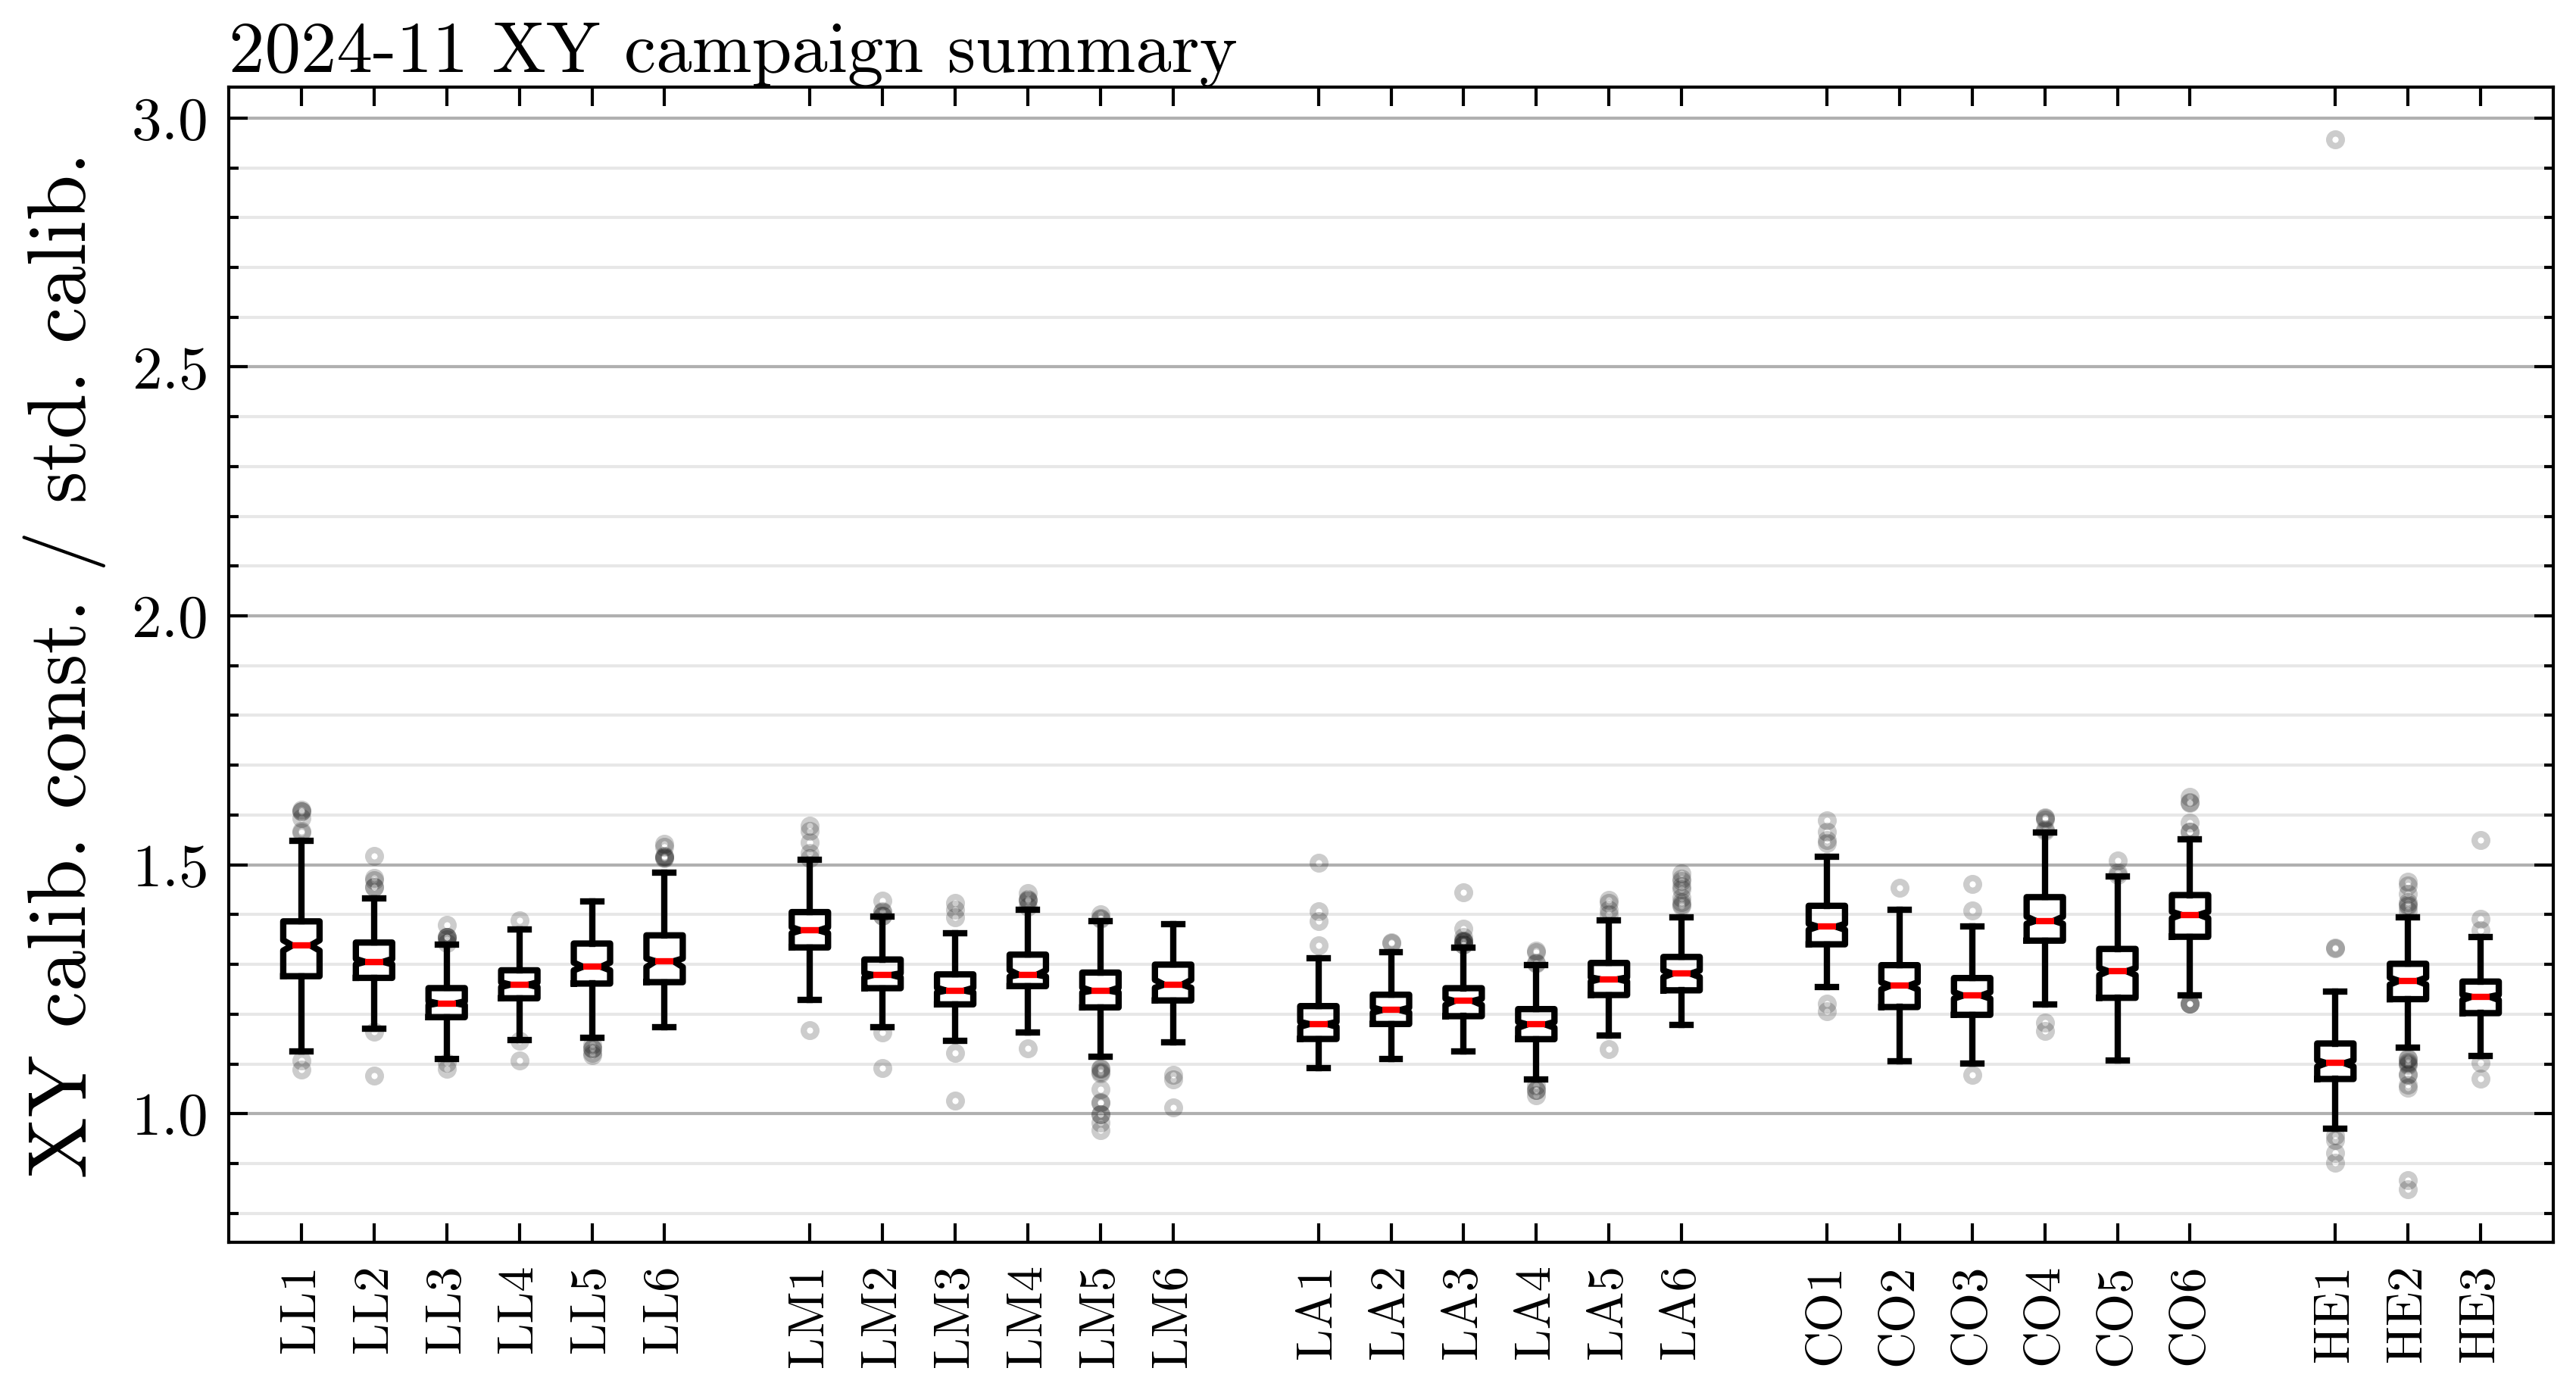

In [3]:
from utils.auger.fd import XYScanner

test = XYScanner.Campaign(2024, 11)
test.summary(normalize='cala', xmin=0.8, xmax=1.7)

In [ ]:
for run in test:
    print(run)

In [ ]:
print(test)

In [ ]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

fIn = "/cr/data01/filip/xy-calibration/campaign_summary/calib_runs_2024-11_OLO_results.csv"

df = pd.read_csv(fIn, comment='#', index_col=0,
                     dtype=defaultdict(lambda: str, global_pixel=int, mirror=int, 
                                       local_pixel=int, col=int, row=int))
df.columns = df.columns.str.strip()  # remove space in keys
label = fIn
label = label.replace("calib_runs_", "").replace("_results", "")

# because there may be nans in the cal_xy col
# pandas parses it as a default string, need to convert
df["cal_xy"] = df['cal_xy'].str.strip()
df["cal_xy"] = df["cal_xy"].astype(float)
df["mirror"] = df["mirror"].astype(float)

dfTelMean = df.groupby(["telescope"]).mean(numeric_only=True).reset_index()
plt.plot(dfTelMean["mirror"], dfTelMean["cal_xy"], '.', label=label)

In [ ]:
df.dtypes

In [ ]:
dfTelMean

In [ ]:
import pandas as pd
from collections import defaultdict

def load_runlist(year_month: str) -> pd.DataFrame:
    data = pd.read_csv(
        f"/cr/data01/filip/xy-calibration/config/calib_runlists/calib_runs_{year_month}.list",
        names=["id","tel","step","date","source","mA","forDB","jobfile","comment"],
        dtype=defaultdict(lambda: str, step="int", mA="float", forDB="bool"),
        index_col=0,
        comment="#",
        sep=";",
    )

    for col in ["source", "jobfile", "comment"]:
        data[col] = data[col].map(lambda x: x.strip().replace('"',''))

    return data

def get_xy_runs(runlist: pd.DataFrame) -> pd.DataFrame:
    return runlist[
        runlist['forDB']
        ]

def get_good_xy_runs(runlist: pd.DataFrame) -> pd.DataFrame:
    return runlist[
        runlist['forDB']
        & (runlist['step'] == 6)
        & (runlist['source'] == "OLO")
        & (runlist['mA'] == 15.9)
        & (runlist['comment'] == "")
        ]

def get_cal_a_runs(runlist: pd.DataFrame) -> pd.DataFrame:
    return runlist[
        (runlist['step'] == 0)
        & (runlist['source'] == "")
        & (runlist['mA'] == 0)
        ]

def get_cal_a_open_shutter_runs(runlist: pd.DataFrame) -> pd.DataFrame:
    return runlist[
        (runlist['step'] == 0)
        & (runlist['source'] == "")
        & (runlist['mA'] == 0)
        & (runlist['comment'].str.contains("open shutter"))
        ]

runlist=load_runlist('2024-11')

get_xy_runs(runlist)

In [ ]:
print(runlist['source'] == "OLO")

In [ ]:
runlist.iloc[0]['source']

In [ ]:
from utils.Auger.SD.Simulation import Simulation

In [ ]:
sim = Simulation(name='test_sim', offline='ds_forced_station_triggers', 
                 src='/cr/users/filip/Projects/SSDTriggerEfficiency/SdSimulationReconstructionUpgrade/',
                 PRIMARY='photon')

In [ ]:
# sim.run(191)

In [ ]:
sim.status()

In [ ]:
sim.process()

In [ ]:
sim.status()